In [ ]:
!pip install tensorflow
!pip install opencv-python

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 손글씨 데이터셋 로드 및 전처리 함수
def load_preprocess_data():
    # MNIST 데이터셋 로드 및 전처리
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    # 레이블 원핫 인코딩
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test

# 손글씨 인식 모델 정의 및 훈련 함수
def train_model(x_train, y_train, x_test, y_test):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    # 모델 컴파일 및 훈련
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

    return model


# 데이터셋 로드 및 모델 훈련
x_train, y_train, x_test, y_test = load_preprocess_data()
model = train_model(x_train, y_train, x_test, y_test)


Epoch 1/10
1875/1875 [==============================] - 69s 36ms/step - loss: 0.1269 - accuracy: 0.9610 - val_loss: 0.0560 - val_accuracy: 0.9828
Epoch 2/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0432 - accuracy: 0.9867 - val_loss: 0.0325 - val_accuracy: 0.9886
Epoch 3/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.0292 - val_accuracy: 0.9890
Epoch 4/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.0294 - val_accuracy: 0.9899
Epoch 5/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0266 - val_accuracy: 0.9913
Epoch 6/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0270 - val_accuracy: 0.9915
Epoch 7/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.0296 -

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [ ]:
# Grad-CAM을 통한 주목 영역 시각화 함수
import tensorflow as tf

def grad_cam(image, model, class_idx):
    # Convert image to a TensorFlow tensor if it's not already one
    if not isinstance(image, tf.Tensor):
        image = tf.convert_to_tensor(image, dtype=tf.float32)  # Ensure dtype matches model's expected input

    # Add batch dimension if it's missing
    if len(image.shape) == 3:
        image = tf.expand_dims(image, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, image)

    # Verify grads dimensionality and perform operations based on your earlier code
    assert len(grads.shape) == 4, "grads should be a 4D tensor"
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads[..., tf.newaxis], image), axis=-1)

    return heatmap


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def apply_transformations(image, heatmap, transformation_type):
    if isinstance(heatmap, tf.Tensor):
        heatmap = heatmap.numpy()  # Convert to numpy array

    if heatmap.ndim == 4:
        heatmap = np.squeeze(heatmap)  # Remove batch dimension
    if heatmap.ndim > 2:
        heatmap = heatmap[..., 0]  # Assuming heatmap is a single-channel image

    mask = cv2.resize(heatmap, (image.shape[2], image.shape[1]))  # Resize to match image dimensions

    # Ensure image is properly formatted for OpenCV
    image = np.squeeze(image)  # Remove batch dimension if present
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Convert to uint8 if necessary

    transformed_image = image.copy()
    if transformation_type == 'noise':
        noise = np.random.normal(loc=0, scale=1, size=image.shape)
        transformed_image = image + mask[..., np.newaxis] * noise
    elif transformation_type == 'blur':
        transformed_image = cv2.GaussianBlur(image, (5, 5), 0) * (1 - mask[..., np.newaxis]) + image * mask[..., np.newaxis]
    elif transformation_type == 'rotate':
        angle = np.random.uniform(-10, 10)
        center = (image.shape[1]//2, image.shape[0]//2)  # Adjust center calculation
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
        transformed_image = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]))
    elif transformation_type == 'brightness':
        factor = np.random.uniform(0.5, 1.5)
        transformed_image = np.clip(image * factor, 0, 255)

    return transformed_image

# Example use case, assuming proper image preprocessing
# transformed_image = apply_transformations(image, heatmap, 'rotate')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image):
    # Remove single-dimensional entries from the shape
    image = np.squeeze(image)

    # Check if the image is still not 2D
    if image.ndim != 2:
        raise ValueError("Image must be 2D to display as grayscale.")

    plt.imshow(image, cmap='gray')
    plt.colorbar()  # Optionally add a colorbar to see image intensities
    plt.show()

In [ ]:
def automated_attack(model, x_test, y_test, iterations=3):
    image_index = 4
    original_image = x_test[image_index:image_index + 1]  # Start with correct shape (1, 28, 28, 1)

    for iteration in range(iterations):
        class_idx = np.argmax(y_test[image_index])
        heatmap = grad_cam(original_image, model, class_idx)  # Ensure grad_cam handles (1, 28, 28, 1) input properly

        transformation_type = np.random.choice(['noise', 'blur', 'rotate', 'brightness'])
        transformed_image = apply_transformations(original_image[0], heatmap, transformation_type)  # Pass (28, 28) image

        print("transformation_type, {}".format(transformation_type))
        print("transformed_image_shape, {}".format(transformed_image.shape))

        # Reshape for model prediction
        prediction = model.predict(transformed_image.reshape(1, 28, 28, 1))
        predicted_label = np.argmax(prediction)

        print(f"Iteration {iteration + 1}:")
        print(f"Transformation type: {transformation_type}")
        print(f"Predicted label: {predicted_label}")

        display_image(transformed_image)

        # Update original_image for next iteration; ensure it is correctly reshaped
        original_image = transformed_image.reshape(1, 28, 28, 1)

        image_index = (image_index + 1) % len(x_test)  # Cycle through test set

def apply_transformations(image, heatmap, transformation_type):
    if transformation_type == 'noise':
        # heatmap의 차원을 image와 일치시키기
        if len(heatmap.shape) > 2:
            heatmap = np.squeeze(heatmap)
        if len(image.shape) > 2:
            image = np.squeeze(image)  # 이를 통해 image가 (28, 28) 형태를 가지도록 함

        # Apply noise dependent on heatmap
        noise = np.random.normal(0, 0.1, image.shape)
        noise = noise * heatmap  # heatmap을 사용해 특정 영역에 더 많은 노이즈 추가
        transformed_image = image + noise
        transformed_image = np.clip(transformed_image, 0, 1)  # 값의 범위를 [0, 1]로 제한

        return transformed_image.reshape(28, 28)  # 모델 입력에 맞게 차원을 명시적으로 설정

    elif transformation_type == 'blur':
        return cv2.GaussianBlur(image, (5, 5), 0)

    elif transformation_type == 'rotate':
        angle = np.random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((14, 14), angle, 1)
        return cv2.warpAffine(image, M, (28, 28))

    elif transformation_type == 'brightness':
        factor = np.random.uniform(0.9, 1.1)
        return np.clip(image * factor, 0, 1)


def display_image(image):
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.show()


transformation_type, blur
transformed_image_shape, (28, 28)
1/1 [==============================] - 0s 38ms/step
Iteration 1:
Transformation type: blur
Predicted label: 4


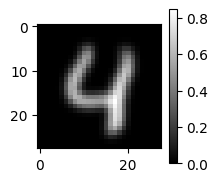

transformation_type, rotate
transformed_image_shape, (28, 28)
1/1 [==============================] - 0s 41ms/step
Iteration 2:
Transformation type: rotate
Predicted label: 4


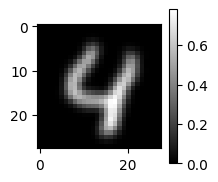

transformation_type, brightness
transformed_image_shape, (28, 28, 1)
1/1 [==============================] - 0s 31ms/step
Iteration 3:
Transformation type: brightness
Predicted label: 4


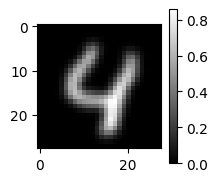

In [ ]:
# 실행
automated_attack(model, x_test, y_test)